In [4]:
%matplotlib inline

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Dataset subclass

In [80]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False,
                 subset=None):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
            - subset: the number of examples from each class to include in dataset
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            
            if subset is not None:
                assert type(subset) is int, 'argument subset must be of type int'
                filenames = filenames[:subset]
            
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# Create MNIST dataset

In [81]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, 
    transform=transforms.ToTensor(),
    subset = 1000
)

# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, 
    transform=transforms.ToTensor(),
    subset = 200
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [82]:
print(len(trainset))
print(len(testset))

10000
2000


In [83]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


# Define a model architecture

In [84]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv4 = nn.Conv2d(20, 20, kernel_size=3)
        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d( self.conv2(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d( self.conv4(self.conv3(x)), 2))
        x = x.view(-1, 20*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [85]:
# Functionality to save model
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

# Load model from previously trained model

In [86]:
path = 'mnist_nn_model'

# The loaded model was trained for 10 epochs on the full MNIST dataset. 
# Trained model achieved 98% accuracy on test set.

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

load_checkpoint(path, model, optimizer) # load from the previously trained model

model loaded from mnist_nn_model


# Test trained model

True label: 4
Predicted label: 4


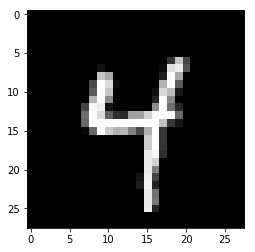

In [100]:
# Test how good the model is
t, t_label = testset[np.random.randint(len(testset))] # Get one training example to work with
t = t.unsqueeze(0) # Unsqueeze to add extra dimension (nn.Module only accepts batches not single examples)
pred = model(t)
pred = pred.max(1, keepdim=True)[1][0,0]

print('True label: {}'.format(t_label))
print('Predicted label: {}'.format(pred))
plt.imshow(t.numpy()[0,0], cmap='binary_r')
plt.show()


# Create function that generates adversarial inputs

In [101]:
def compare_plots(natural, perturbation, adversary):
    plt.subplot(1,3,1)
    plt.imshow(natural.numpy()[0,0], cmap='binary_r')
    plt.title('Natural Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,2)
    plt.imshow(perturbation.numpy()[0,0], cmap='binary_r')
    plt.title('Perturbation')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1,3,3)
    plt.imshow(adversary.numpy()[0,0], cmap='binary_r')
    plt.title('Adversarial Image')
    plt.xticks([])
    plt.yticks([])

    plt.show()


In [105]:
dataiter = iter(trainset_loader)
batch_images, batch_labels = dataiter.next()

Process Process-1:
Traceback (most recent call last):
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/justinpyron/anaconda3/envs/cs231/lib/python3.6

In [150]:
output = model(batch_images)

In [161]:
batch_images.requires_grad_(True)

output = model(batch_images)
model.zero_grad()
dout = torch.ones_like(output, dtype=torch.float)
grad = torch.autograd.grad(outputs=output, inputs=batch_images, grad_outputs=dout)

In [152]:
print('batch_images size: {}'.format(batch_images.size()))
print('output size: {}'.format(output.size()))
print('grad size: {}'.format(grad.size()))


batch_images size: torch.Size([64, 1, 28, 28])
output size: torch.Size([64, 10])
grad size: torch.Size([64, 1, 28, 28])


In [191]:
pred = model(batch_images)

In [194]:
torch.argmax(model(batch_images),1)

tensor([ 5,  9,  6,  2,  7,  5,  0,  1,  4,  1,  0,  3,  5,  5,
         0,  0,  6,  2,  0,  5,  3,  5,  2,  6,  2,  5,  2,  0,
         9,  8,  0,  6,  0,  8,  3,  3,  5,  6,  1,  4,  1,  0,
         5,  5,  3,  4,  4,  7,  0,  6,  3,  6,  5,  5,  1,  0,
         5,  9,  3,  3,  0,  2,  5,  0])

In [227]:
def batch_JSMA(input_imgs, model, target, num_pixels=10, num_iters=1000, target_weight=9):
    '''
    Generate adversarial images utilizing the Jacobian based Saliency
    Map Approach. 
    Arguments:
        - input_imgs: torch tensor of input images
        - input labels: torch tensor of class labels
        - model: model used to make predictions
        - target class: class to trick the model into predicting
        - num_pixels: the number of pixels to change in each update
        - num_iters: maximum number of times to add a perturbation to image
        - target_weight: how much to weight the gradient w.r.t. target class
            relative to all other classes
    '''
    batch_size = input_imgs.size()[0]
    input_imgs = input_imgs.clone()
    input_imgs.requires_grad_(True)  # very important!
    
    perturbation = torch.zeros_like(input_imgs)
    fooled = False
    iteration = 0

    # We want to increase score of target and decrease score of
    # all other classes; so, have upstream gradient flowing to
    # target be positive and to all others be negative
    dout = -1. * torch.ones_like(model(input_imgs), dtype=torch.float) * 0.
    dout[:,target] = target_weight
    
    required_iters = torch.zeros(batch_size)

    while fooled is False and iteration < num_iters:
        
        output = model(input_imgs)
        model.zero_grad() # zero out all gradients in model so they don't accumulate
        grad = torch.autograd.grad(outputs=output, inputs=input_imgs, grad_outputs=dout)[0]
        
        with torch.no_grad():
            # Get the k largest values of gradient matrix. K = num_pixels
            flattened = grad.view(grad.size()[0],-1)
            kth_largest = -(-flattened).kthvalue(num_pixels,1)[0]
            kth_largest = kth_largest.unsqueeze(1).unsqueeze(1).unsqueeze(1) # make broadcastable with grad 
            grad[torch.ge(grad,kth_largest) == 0] = 0
            grad = grad*1e-2

            perturbation.add_(grad).clamp_(0,1)
            input_imgs.add_(grad).clamp_(0,1)
            
            predictions = torch.argmax(model(input_imgs), 1)
            
            # If an example is correctly predicted, set all upward gradients
            # flowing to that example to zero; we've successfully found an
            # adversarial image that tricks the model and no longer need to 
            # update the original. We keep looping to find successfull
            # adversarial images for the other examples.
            mask = torch.diag(predictions != target).type(torch.float)
            dout = torch.matmul(mask, dout)
            required_iters.add_( (predictions != target).type(torch.float) )
            
            if (predictions == target).sum() == batch_size: # If fooled for example
                fooled = True
            iteration += 1
            
    return (perturbation.detach(), input_imgs.detach(), required_iters)

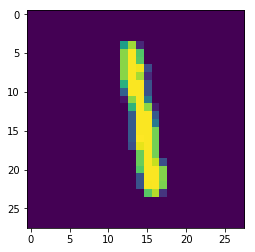

In [110]:
plt.imshow(batch_images[4][0])
plt.show()

In [205]:
batch_images.size()

torch.Size([64, 1, 28, 28])

In [228]:
target = 7
import time
begin = time.time()
pers, advs, req_iters = batch_JSMA(batch_images, model, target, num_pixels=40, num_iters=200)
print('Took {} seconds'.format(time.time() - begin))

Took 19.018969774246216 seconds


In [230]:
req_iters

tensor([ 200.,  200.,   11.,   96.,    9.,  200.,   19.,  200.,  200.,
         200.,   72.,  200.,   36.,   29.,    0.,   12.,    4.,    5.,
          55.,   56.,  200.,    4.,  200.,   16.,  141.,    1.,  200.,
           6.,    0.,   69.,  200.,  200.,   13.,   12.,  200.,   28.,
         200.,   27.,    3.,  200.,    9.,    0.,   10.,    0.,   10.,
          19.,   45.,   22.,   17.,   56.,    0.,   37.,   19.,    3.,
         200.,    8.,  200.,    2.,  200.,  200.,    8.,  200.,   14.,
         200.])

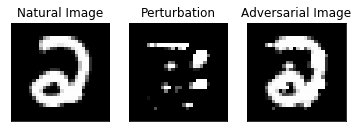

In [231]:
j = 0
natural = batch_images[j].detach().unsqueeze(0)
pert = pers[j].unsqueeze(0)
adv = advs[j].unsqueeze(0)

compare_plots(natural, pert, adv)

In [233]:
a = torch.randint(1,99,(2,5,3))
a

tensor([[[ 36.,  69.,  43.],
         [ 54.,  36.,  12.],
         [ 94.,  79.,  21.],
         [ 17.,  35.,  11.],
         [ 18.,  53.,  23.]],

        [[ 73.,  82.,  36.],
         [ 93.,   5.,  24.],
         [ 62.,  13.,  87.],
         [ 36.,  48.,  87.],
         [ 34.,  46.,  88.]]])

In [196]:
b = a.view(a.size()[0],-1)
b

tensor([[  6.,  31.,  67.,   4.,  11.,  96.,  32.,  93.,  61.,  83.,
          77.,  58.,  61.,  26.,  35.],
        [ 60.,  92.,  54.,  86.,  54.,  84.,  45.,  40.,  85.,  10.,
          57.,  72.,  72.,  97.,  33.]])

In [197]:
c = -(-b).kthvalue(3,1)[0]
c

tensor([ 83.,  86.])

In [198]:
d = c.unsqueeze(1).unsqueeze(1)
d

tensor([[[ 83.]],

        [[ 86.]]])

In [189]:
e = a
e[torch.ge(a,d) == 0] = 0
e

tensor([[[ 98.,   0.,   0.],
         [  0.,   0.,  88.],
         [  0.,   0.,   0.],
         [ 94.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,  93.,   0.],
         [  0.,  92.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,  92.]]])

True class: 2
Target class: 7
Predicted class: 2


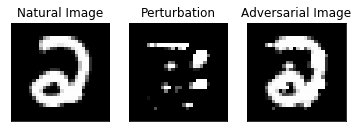

True class: 3
Target class: 7
Predicted class: 3


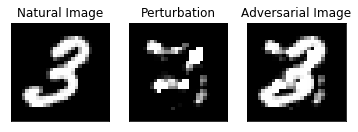

True class: 2
Target class: 7
Predicted class: 7


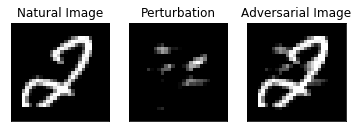

True class: 8
Target class: 7
Predicted class: 7


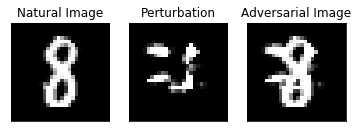

True class: 1
Target class: 7
Predicted class: 7


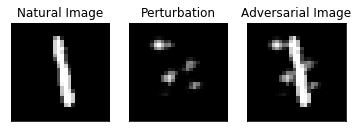

True class: 8
Target class: 7
Predicted class: 8


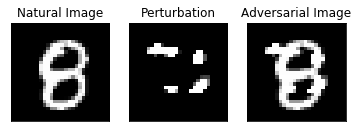

True class: 6
Target class: 7
Predicted class: 7


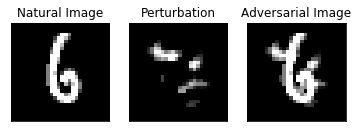

True class: 5
Target class: 7
Predicted class: 8


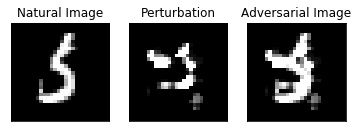

True class: 8
Target class: 7
Predicted class: 8


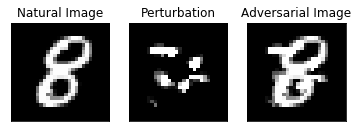

True class: 3
Target class: 7
Predicted class: 3


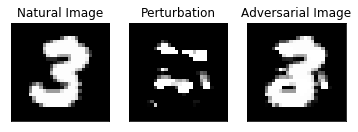

True class: 8
Target class: 7
Predicted class: 7


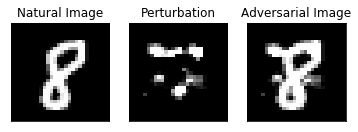

True class: 2
Target class: 7
Predicted class: 2


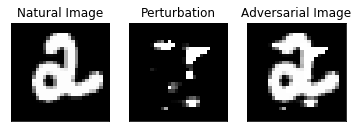

True class: 3
Target class: 7
Predicted class: 7


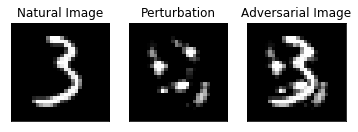

True class: 4
Target class: 7
Predicted class: 7


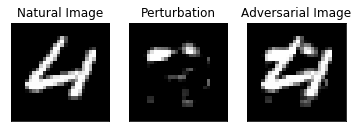

True class: 6
Target class: 7
Predicted class: 7


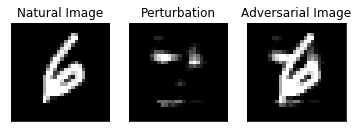

True class: 1
Target class: 7
Predicted class: 7


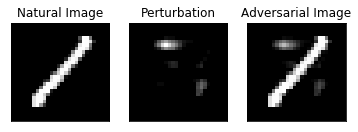

True class: 1
Target class: 7
Predicted class: 7


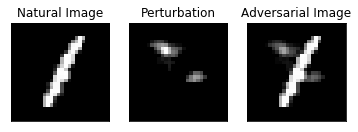

True class: 5
Target class: 7
Predicted class: 7


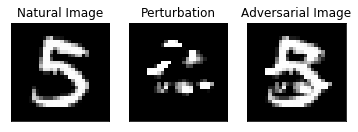

True class: 3
Target class: 7
Predicted class: 7


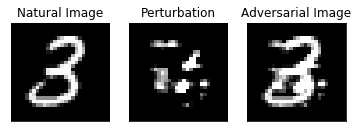

True class: 0
Target class: 7
Predicted class: 0


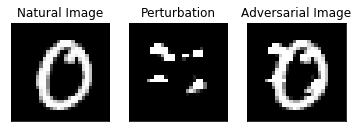

True class: 1
Target class: 7
Predicted class: 7


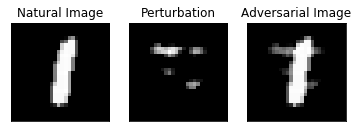

True class: 2
Target class: 7
Predicted class: 3


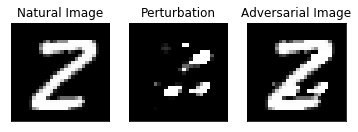

True class: 4
Target class: 7
Predicted class: 7


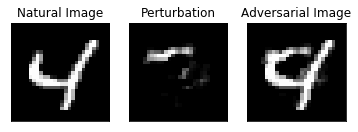

True class: 6
Target class: 7
Predicted class: 7


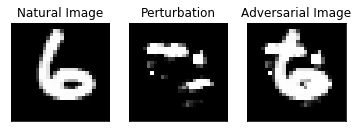

True class: 1
Target class: 7
Predicted class: 7


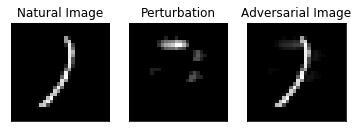

True class: 3
Target class: 7
Predicted class: 3


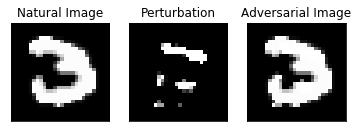

True class: 4
Target class: 7
Predicted class: 7


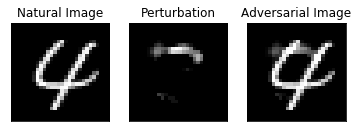

True class: 6
Target class: 7
Predicted class: 7


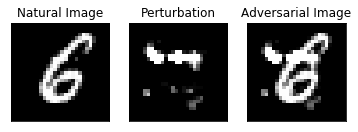

True class: 8
Target class: 7
Predicted class: 3


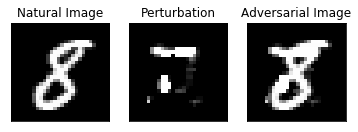

True class: 0
Target class: 7
Predicted class: 0


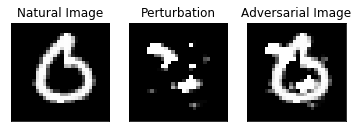

True class: 9
Target class: 7
Predicted class: 7


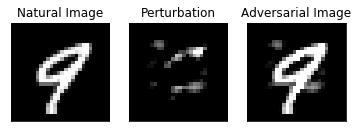

True class: 8
Target class: 7
Predicted class: 7


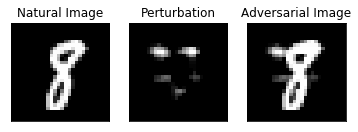

True class: 2
Target class: 7
Predicted class: 8


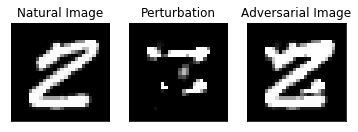

True class: 3
Target class: 7
Predicted class: 7


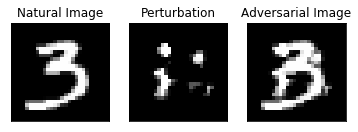

True class: 8
Target class: 7
Predicted class: 8


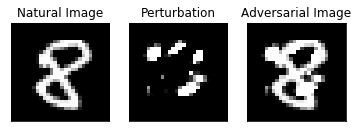

True class: 5
Target class: 7
Predicted class: 7


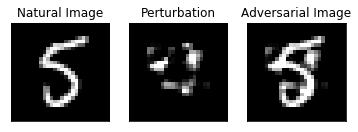

True class: 1
Target class: 7
Predicted class: 7


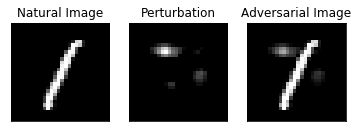

True class: 8
Target class: 7
Predicted class: 8


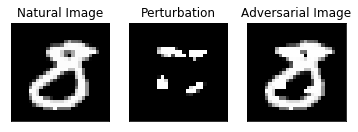

True class: 5
Target class: 7
Predicted class: 7


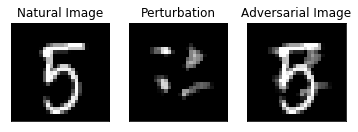

True class: 9
Target class: 7
Predicted class: 7


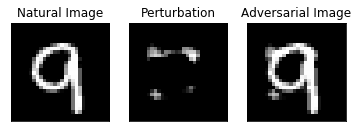

True class: 2
Target class: 7
Predicted class: 7


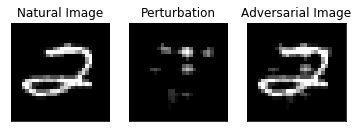

True class: 2
Target class: 7
Predicted class: 7


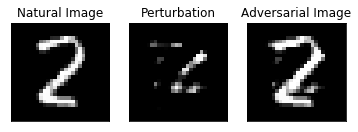

True class: 8
Target class: 7
Predicted class: 7


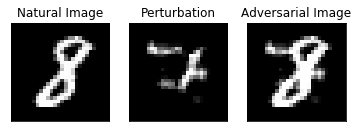

True class: 3
Target class: 7
Predicted class: 7


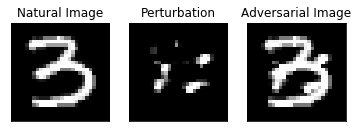

True class: 5
Target class: 7
Predicted class: 7


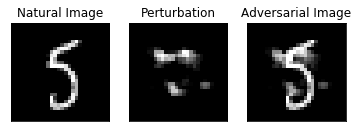

True class: 6
Target class: 7
Predicted class: 7


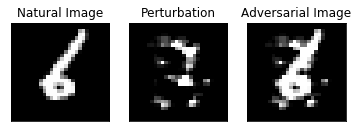

True class: 3
Target class: 7
Predicted class: 7


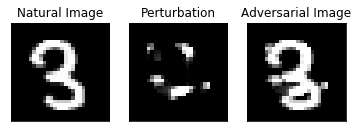

True class: 8
Target class: 7
Predicted class: 7


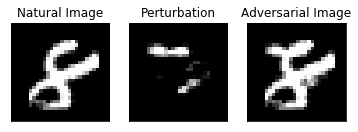

True class: 1
Target class: 7
Predicted class: 7


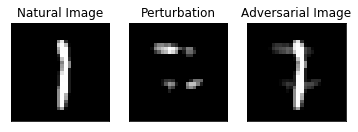

True class: 5
Target class: 7
Predicted class: 8


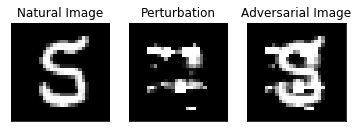

True class: 2
Target class: 7
Predicted class: 7


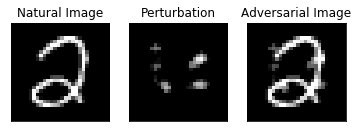

True class: 0
Target class: 7
Predicted class: 0


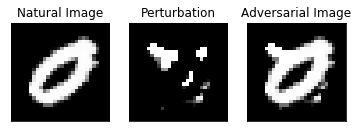

True class: 1
Target class: 7
Predicted class: 7


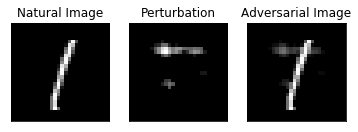

True class: 0
Target class: 7
Predicted class: 2


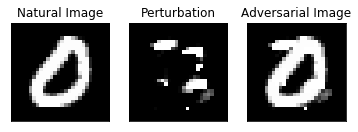

True class: 5
Target class: 7
Predicted class: 8


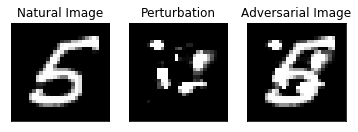

True class: 9
Target class: 7
Predicted class: 7


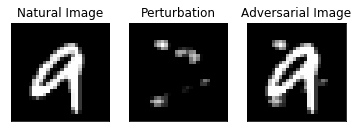

True class: 6
Target class: 7
Predicted class: 8


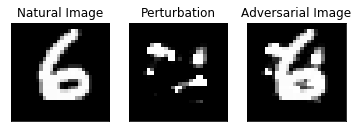

True class: 0
Target class: 7
Predicted class: 7


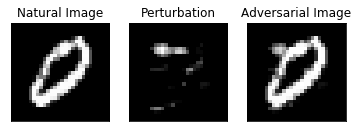

True class: 2
Target class: 7
Predicted class: 2


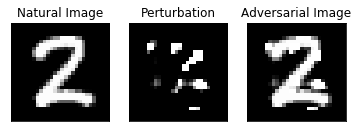

In [232]:

for j in range(len(batch_images)):

    natural = batch_images[j].detach().unsqueeze(0)
    pert = pers[j].unsqueeze(0)
    adv = advs[j].unsqueeze(0)
    
    if target == batch_labels[j]:
        continue

    print('True class: {}'.format(batch_labels[j]))
    print('Target class: {}'.format(target))
    print('Predicted class: {}'.format(torch.argmax(model(adv), 1).item()))

    compare_plots(natural, pert, adv)



In [341]:
advs.size()
advs[0]

torch.Size([1, 28, 28])

In [455]:
class MNIST_specific_label(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 class_label,
                 transform=None):
        """ Create a dataset of images from MNIST belonging to a specific class
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - class_label: the label of the class to generate dataset for
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        filenames = glob.glob(osp.join(root, str(class_label), '*.png'))

#         for fn in filenames:
        for fn in filenames[:10]:
            self.filenames.append((fn, class_label)) # (filename, label) pair
                
        self.len = len(self.filenames)
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image_fn, label = self.filenames[index]
        image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

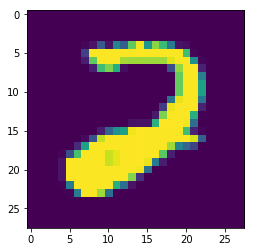

In [306]:
t = MNIST_specific_label(root='mnist_png/training', transform=transforms.ToTensor(), class_label=2)

plt.imshow(t[50][0].numpy()[0])
plt.show()

In [307]:
t = MNIST_specific_label(root='mnist_png/training', transform=transforms.ToTensor(), class_label=2)
t_loader = DataLoader(t, batch_size=50, shuffle=False, num_workers=1)

120

In [459]:
for i, (data, label) in enumerate(t_loader):
#     preds = model(data).argmax(1)
    print(i, data.size())
    


0 torch.Size([50, 1, 28, 28])
1 torch.Size([50, 1, 28, 28])
2 torch.Size([50, 1, 28, 28])
3 torch.Size([50, 1, 28, 28])
4 torch.Size([50, 1, 28, 28])
5 torch.Size([50, 1, 28, 28])
6 torch.Size([50, 1, 28, 28])
7 torch.Size([50, 1, 28, 28])
8 torch.Size([50, 1, 28, 28])
9 torch.Size([50, 1, 28, 28])
10 torch.Size([50, 1, 28, 28])
11 torch.Size([50, 1, 28, 28])
12 torch.Size([50, 1, 28, 28])
13 torch.Size([50, 1, 28, 28])
14 torch.Size([50, 1, 28, 28])
15 torch.Size([50, 1, 28, 28])
16 torch.Size([50, 1, 28, 28])
17 torch.Size([50, 1, 28, 28])
18 torch.Size([50, 1, 28, 28])
19 torch.Size([50, 1, 28, 28])
20 torch.Size([50, 1, 28, 28])
21 torch.Size([50, 1, 28, 28])
22 torch.Size([50, 1, 28, 28])
23 torch.Size([50, 1, 28, 28])
24 torch.Size([50, 1, 28, 28])
25 torch.Size([50, 1, 28, 28])
26 torch.Size([50, 1, 28, 28])
27 torch.Size([50, 1, 28, 28])
28 torch.Size([50, 1, 28, 28])
29 torch.Size([50, 1, 28, 28])
30 torch.Size([50, 1, 28, 28])
31 torch.Size([50, 1, 28, 28])
32 torch.Size([50,

In [326]:
print('preds size: {}'.format(preds.size()))
print(preds)
new_preds = preds[preds == 2]

print('preds size: {}'.format(new_preds.size()))


preds size: torch.Size([50])
tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2])
preds size: torch.Size([49])


In [456]:
def save_image(tensor, path):
    '''
    Save the input PyTorch Tensor as a PNG file
    Arguments:
        - tensor: a PyTorch tensor. Expected dimensions are (C,H,W),
                    where C = channels, H = height, W = width
        - path: where to save file
    '''
    
    # Make tensor values fall in range [0,1]
    tensor = tensor - tensor.min()
    tensor = tensor/tensor.max()
    
    tensor = transforms.ToPILImage()(tensor)
    tensor.save(path)

In [464]:

def create_dataset(source_path, batch_size=100):
    '''
    Create dataset of adversarial MNIST images
    arguments:
        - source_path: path of directory holding original MNIST images
    '''

    # Set device
    torch.manual_seed(123)
    device = torch.device('cpu')

    # Load pretrained model
    model = Net().to(device)
    state = torch.load('mnist_nn_model')
    model.load_state_dict(state['state_dict'])
    
    # create directory to store images
    parent_dir = 'MNIST_adversarial'
    os.makedirs(parent_dir)
    
    for class_label in range(10):
        print('\n\nClass label: {}'.format(class_label))
        
        # Create a dataset containing images only of a specific class
        dataset = MNIST_specific_label(root=source_path, 
                                       transform=transforms.ToTensor(), 
                                       class_label=class_label)
        dataset_loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=1)

        # create directory to store images belonging to class_label
        child_dir = '{}{}{}'.format(parent_dir, '/original_', class_label)
        os.makedirs(child_dir)
        
        image_number = 0 # use this when naming files

        # Loop through batches of dataset
        for batch_num, (batch_data, batch_label) in enumerate(dataset_loader):
            if batch_num % 10 == 0:
                print('Class label: {},  Batch {}/{}'.format(class_label, batch_num, len(dataset_loader)))
            
            # Only keep images that model correctly predicts
            predictions = model(batch_data).argmax(1) # max along axis=1
            batch_data = batch_data[predictions == class_label]
            
            # store tensors containing batches of adversarial images in a dict
            adv_dict = dict()
            
            for adversarial_label in range(10):
                if adversarial_label == class_label:
                    continue
                
                # Generate adversarial images
                perturbations, adv_images = batch_FGVM(input_imgs=batch_data, 
                                                      model=model, 
                                                      target=adversarial_label)
                adv_dict[adversarial_label] = adv_images
            
            # save images
            for i in range(len(batch_data)):
                # Make a folder corresponding to each image
                grandchild_dir = '{}{}{}'.format(child_dir, '/image', image_number)
                os.makedirs(grandchild_dir)

                # Save original image
                file_name = '{}{}'.format(grandchild_dir, '/original.png')
                save_image(batch_data[i], file_name)
                
                # Save adversarial images
                for label, adv_images in adv_dict.items():
                    file_name = '{}{}{}{}'.format(grandchild_dir, '/target_', label, '.png')
                    save_image(adv_images[i], file_name)
                
                image_number += 1
                

In [466]:
create_dataset(source_path='mnist_png/training')


Class label: 0

Class label: 0,  Batch 0/1
Class label: 1

Class label: 1,  Batch 0/1
Class label: 2

Class label: 2,  Batch 0/1
Class label: 3

Class label: 3,  Batch 0/1
Class label: 4

Class label: 4,  Batch 0/1
Class label: 5

Class label: 5,  Batch 0/1
Class label: 6

Class label: 6,  Batch 0/1
Class label: 7

Class label: 7,  Batch 0/1
Class label: 8

Class label: 8,  Batch 0/1
Class label: 9

Class label: 9,  Batch 0/1


In [475]:
print('{0:.2f}'.format(1./60))

0.02


In [2]:
s = t
print(s.min())
s = s - s.min()
print(s.min())

print(s.max())
s = s/s.max()
print(s.max())

s = s*255
print(s.min())
print(s.max())





NameError: name 't' is not defined